### Librerías requeridas

In [89]:
#python and matplotlib libraries
import numpy as np
import math 
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec

#machine learning libraries
from skimage import feature
from skimage.transform import hough_line, hough_line_peaks

import cv2 as cv

### Importación de archivos

Imagenes/label_points.png


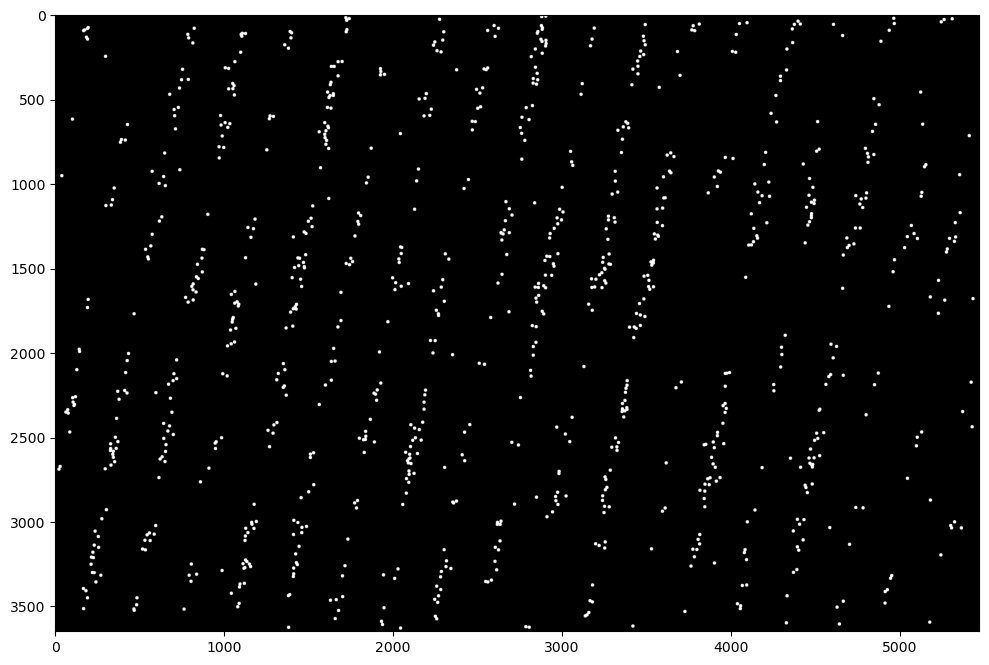

In [93]:
path = [
    '3m60/503_120_29.jpg', # Orientación horizontal
    '3m60/503_121_43.jpg',
    '3,5m90/503_119_43.jpg', # Orientación vertical
    '3m90/503_118_29.jpg',
    '3,5m90/209_101_24.jpg', # Etiquetada
    '3m60/209_416_15.jpg', # Etiquetada
    '5m90/Eryx/DJI_0287.JPG',
    'label_points.png' # Mapa de puntos (etiquetado)
]

open = 'Imagenes/'+path[7]
print(open)
image = cv.imread(open)

im_color = cv.cvtColor(image, cv.COLOR_BGR2RGB)
#im_color = cv.imread(image, cv.IMREAD_UNCHANGED)
fig = plt.figure(figsize=(12,8))
plt.imshow(im_color)
plt.show()
im = im_color

# EXPERIMENTOS
__*Método 0 - Umbral fijo (50): (ExG, Canny 2, Hough 2)*__

- 503_120_29 -> 17/17 lineas (100%)
- 503_121_43 -> 14/19 lineas (74%)
- 503_119_43 -> 21/24 lineas (88%)
- 209_206_54 -> 12/20 lineas (60%) _thresh 100_

__*Método 0 - Umbral fijo (50): (ExG, Canny 3, Hough 2)*__

- 503_120_29 -> 16/17 lineas (94%)
- 503_121_43 -> 16/19 lineas (84%)
- 503_119_43 -> 21/24 lineas (88%)
- 209_206_54 -> 11/20 lineas (55%) thresh 100


__*Método 1 - OTSU: (ExG + Mask, Canny 2, Hough 2)*__

- 503_120_29 -> 14/17 lineas (82%)
- 503_121_43 -> 15/19 lineas (79%)
- 503_119_43 -> 19/24 lineas (79%)
- 209_206_54 -> 16/20 lineas (80%)

__*Método 3 - Percentiles: (ExG + Mask, Canny 2, Hough 2)*__

- 503_120_29 -> 14/17 lineas (82%)
- 503_121_43 -> 16/19 lineas (84%)
- 503_119_43 -> 21/24 lineas (88%)
- 209_206_54 -> 15/20 lineas (75%)

In [94]:
original = im_color
original.shape

(3648, 5472, 3)

In [95]:
# Dowscaling
#im_color = cv.pyrDown(im_color)
im_color.shape

(3648, 5472, 3)

## Pruebas con espacios de color

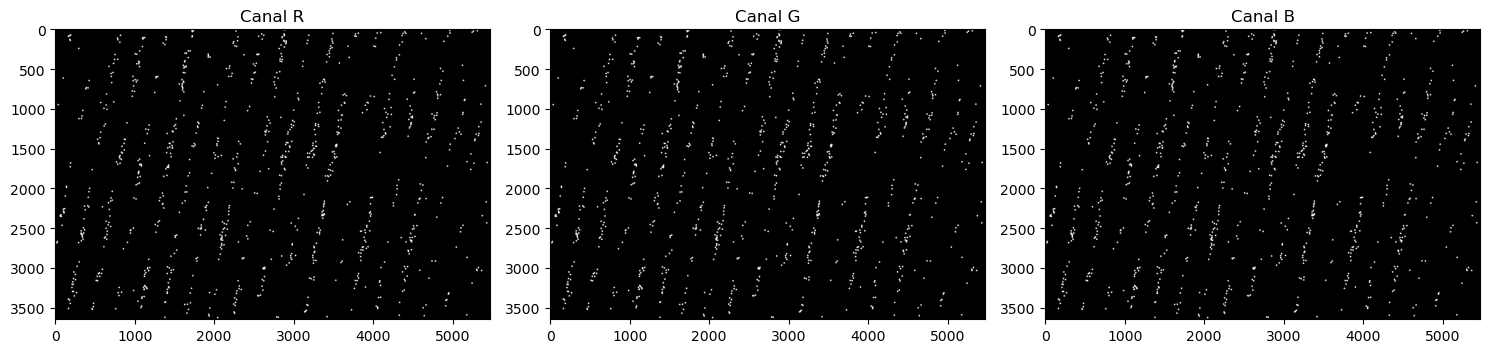

In [96]:
# Extraer los canales R, G, B
img_RGB = im_color
R, G, B = cv.split(img_RGB)

# Mostrar cada canal individual
fig = plt.figure(figsize=(15, 5))

ax1=plt.subplot(131)
ax1.imshow(R, vmin=0, vmax=255,cmap='gray')
ax1.set_title('Canal R')

ax2=plt.subplot(132)
ax2.imshow(G, vmin=0, vmax=255,cmap='gray')
ax2.set_title('Canal G')

ax3=plt.subplot(133)
ax3.imshow(B, vmin=0, vmax=255,cmap='gray')
ax3.set_title('Canal B')

plt.tight_layout()
plt.show()

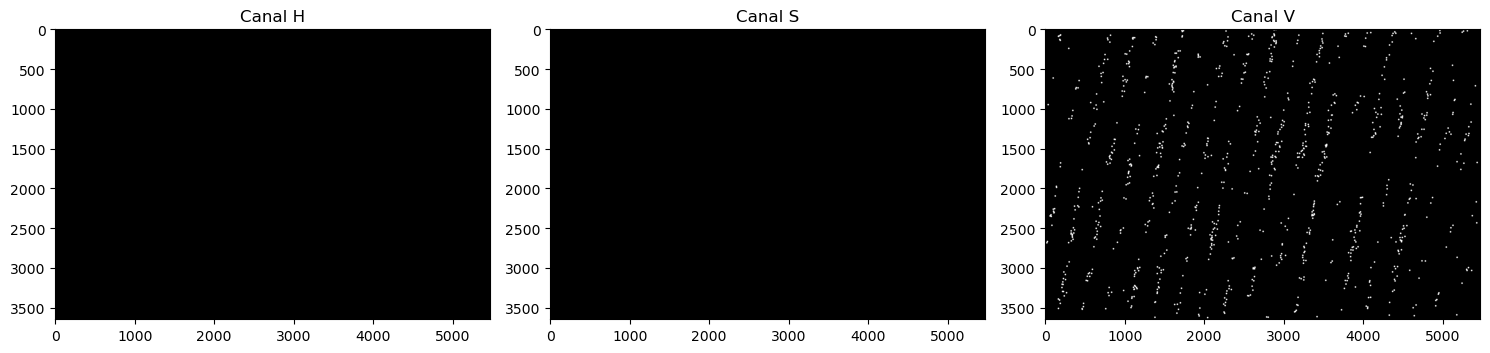

In [97]:
# Extraer los canales H, S, V
img_HSV = cv.cvtColor(im_color, cv.COLOR_RGB2HSV)
H, S, V = cv.split(img_HSV)

# Mostrar cada canal individual
fig = plt.figure(figsize=(15, 5))

ax1=plt.subplot(131)
ax1.imshow(H, vmin=0, vmax=179,cmap='gray')
ax1.set_title('Canal H')

ax2=plt.subplot(132)
ax2.imshow(S, vmin=0, vmax=255,cmap='gray')
ax2.set_title('Canal S')

ax3=plt.subplot(133)
ax3.imshow(V, vmin=0, vmax=255,cmap='gray')
ax3.set_title('Canal V')

plt.tight_layout()
plt.show()

**Posibles preprocesamiento de la imagen**

Reducción de ruido:
- Filtro Gaussiano: skimage.filters.gaussian
- Mediana: skimage.filters.median

Mejora de contraste:
- Equalización del histograma: skimage.exposure.equalize_hist.
- CLAHE (Contrast Limited Adaptive Histogram Equalization).


Umbral calculado basado en percentil (90): 0.0


(-0.5, 5471.5, 3647.5, -0.5)

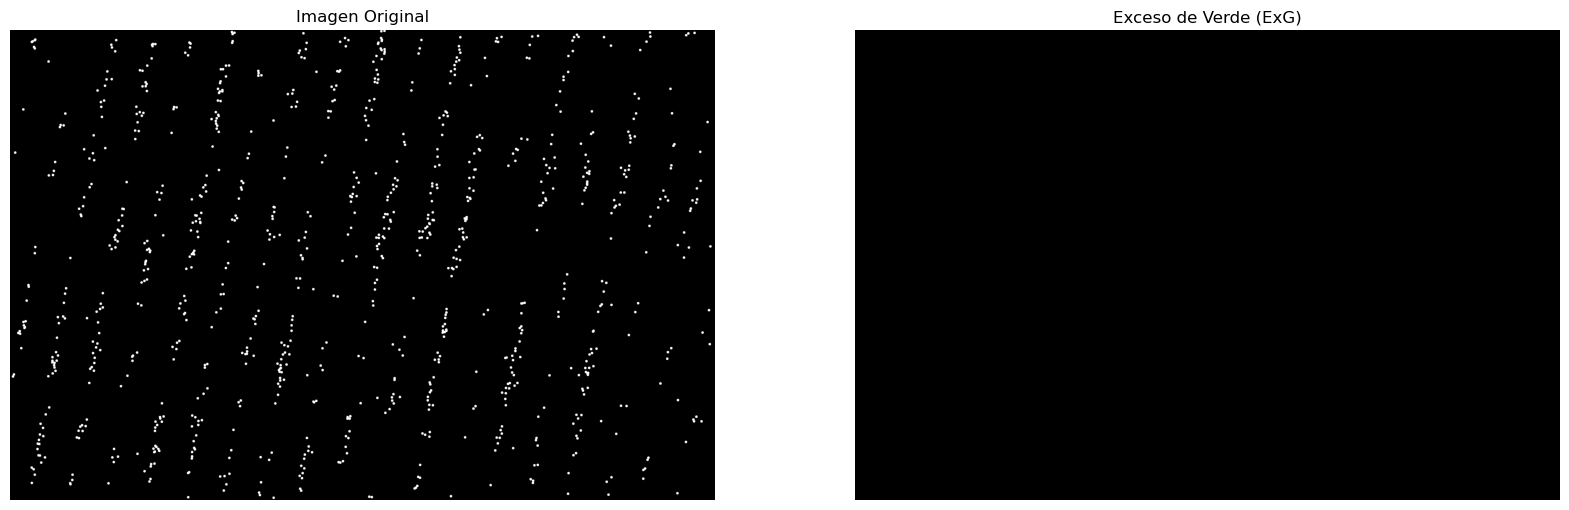

In [98]:

# Convertir a formato float para evitar problemas con saturación al realizar operaciones
image = im_color.astype('float32')
R, G, B = cv.split(image)

# Calcular el exceso de verde (ExG)
ExG = 2 * G - R - B

# Normalizar para visualizar (opcional, solo para visualización)
ExG_norm = cv.normalize(ExG, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype('uint8')

method = 3 # Elegir método a aplicar
if method == 0:
    # Aplicar un umbral fijo
    threshold = 50 #umbral para Excess Green
    _, ExG_thresh = cv.threshold(ExG_norm, threshold, 255, cv.THRESH_BINARY)
elif method == 1:
    # Aplicar el método de Otsu
    _, ExG_thresh = cv.threshold(ExG_norm, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    print(f"Umbral calculado automáticamente por Otsu: {_: .2f}")
elif method == 2: # NO da buenos resultados
    # Umbralización adaptativa (celdas locales)
    ExG_thresh = cv.adaptiveThreshold(ExG_norm, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
elif method == 3:
    # Calcular umbral dinámico basado en percentiles
    percentile = 90
    threshold_value = np.percentile(ExG_norm, percentile)
    # Aplicar umbral
    _, ExG_thresh = cv.threshold(ExG_norm, threshold_value, 255, cv.THRESH_BINARY)
    print(f"Umbral calculado basado en percentil ({percentile}): {threshold_value}")
else:
    print("No se ha aplicado ningún umbral")

# Guardar como imagen
cv.imwrite('exg_result.png', ExG_thresh)

# Mostrar la imagen original y el resultado
plt.figure(figsize=(20, 15))

plt.subplot(1, 2, 1)
plt.imshow(image.astype('uint8'))
plt.title("Imagen Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ExG_thresh, cmap='gray')
plt.title("Exceso de Verde (ExG)")
plt.axis('off')

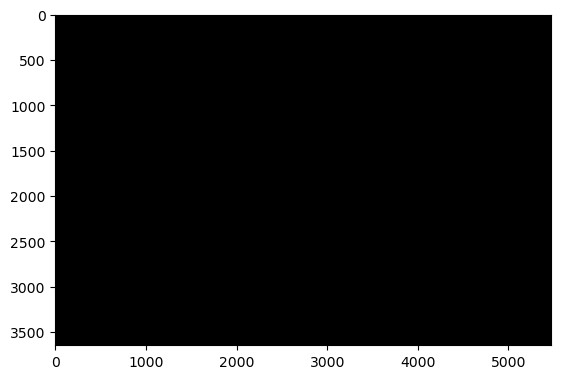

In [99]:
nExG = cv.bitwise_not(ExG_thresh)
plt.imshow(nExG, cmap='gray')

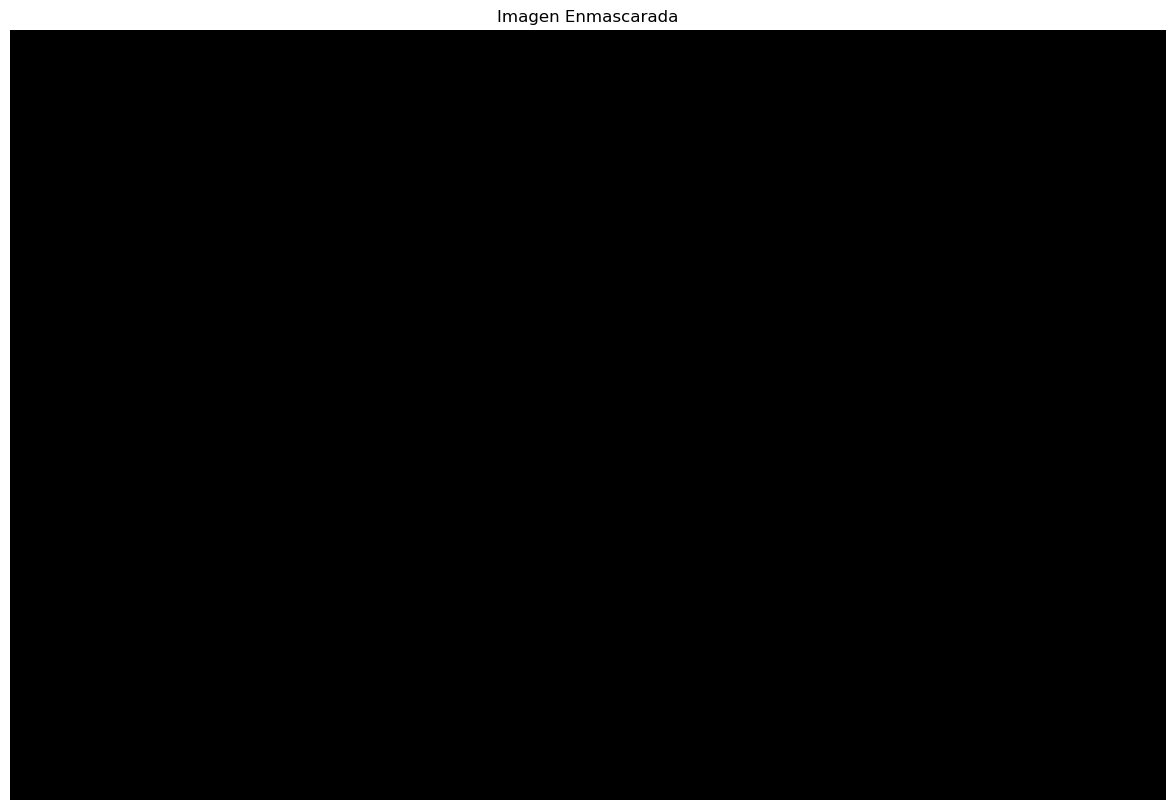

In [100]:
# Convertir la máscara a 3 canales para aplicarla a im_color
ExG_thresh_3ch = cv.merge([ExG_thresh, ExG_thresh, ExG_thresh])

# Aplicar la máscara sobre la imagen original
masked_image = cv.bitwise_and(im_color, ExG_thresh_3ch)

# Mostrar la imagen original, la máscara y la imagen enmascarada
plt.figure(figsize=(25, 10))
plt.plot()
plt.imshow(masked_image.astype('uint8'))
plt.title("Imagen Enmascarada")
plt.axis('off')

plt.show()

In [106]:
im = ExG_thresh.copy()
# masked_image
# ExG_thresh
# Si genera error de dimension (imagen color)
# im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

In [107]:
im = im_color.copy()
masked_image = im
im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
im.shape

(3648, 5472)

## Rotación de la imagen (para pruebas)

(-0.5, 5471.5, 3647.5, -0.5)

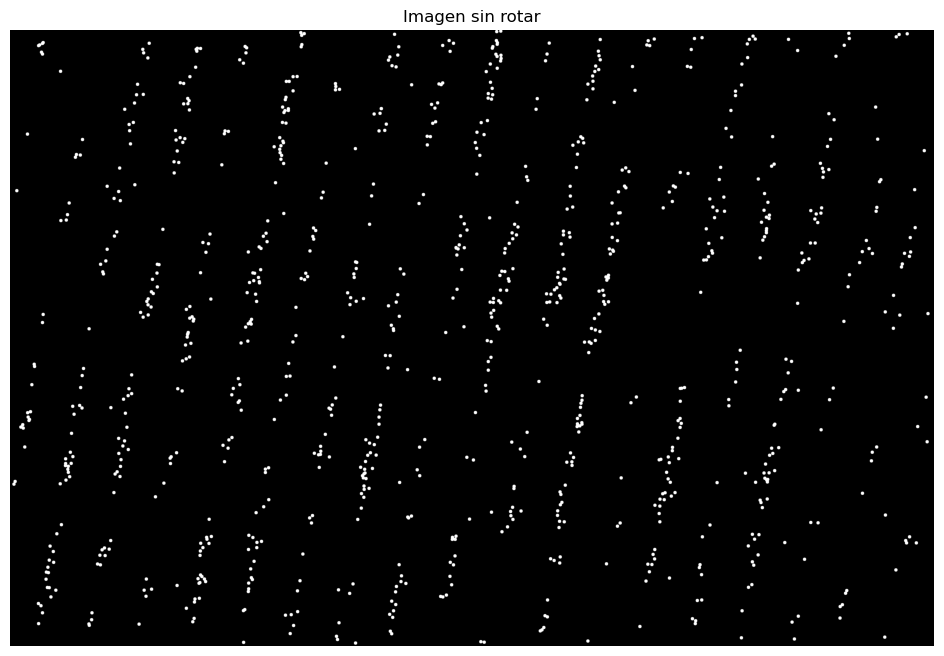

In [108]:
# ROTATION
rotate = False
if rotate:
    rotation = [cv.ROTATE_90_CLOCKWISE, cv.ROTATE_90_COUNTERCLOCKWISE]
    # Rotate the image 90 degrees clockwise
    rotated_im = cv.rotate(ExG_norm, rotation[1])
    im = rotated_im

plt.figure(figsize=(12, 8))
plt.imshow(im, cmap='gray')
plt.title("Imagen rotada" if rotate else "Imagen sin rotar")
plt.axis('off')

# Detección de líneas

### Canny filter

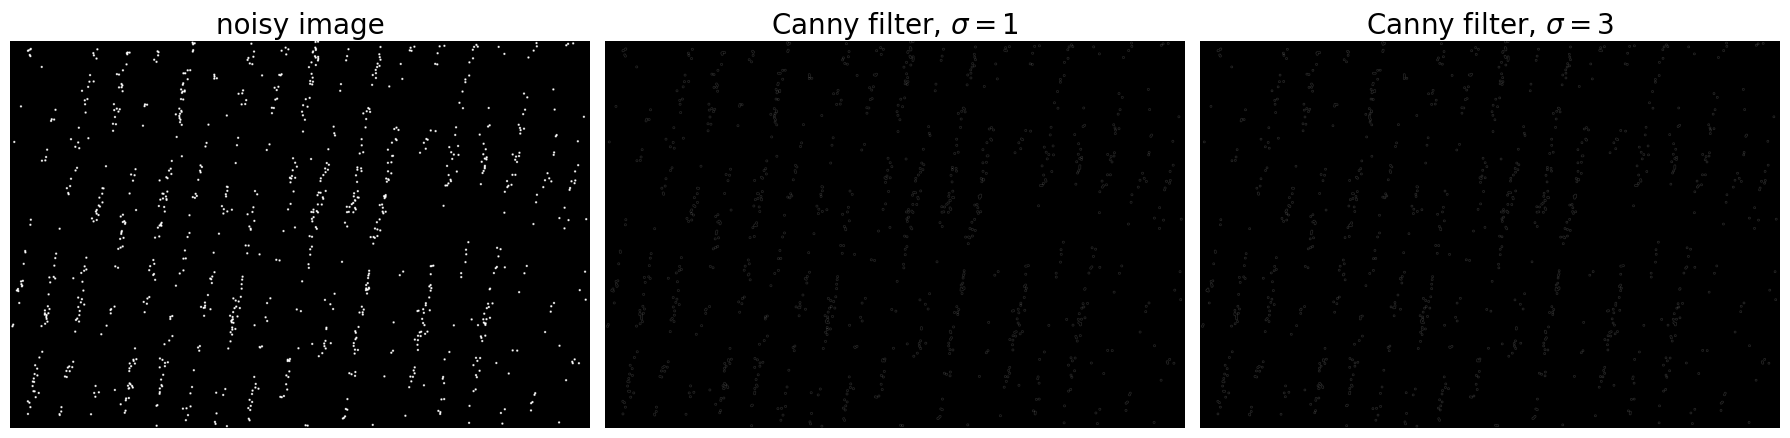

In [109]:
# Compute the Canny filter for two values of sigma
sigma = 3 # Explorar distintos valores de sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=sigma)
# edges = feature.canny(im, sigma=1, low_threshold=50, high_threshold=150) # Explorar distintos thresholds

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(f'Canny filter, $\sigma={sigma}$', fontsize=20)

fig.tight_layout()

plt.show()

### Hough line transform

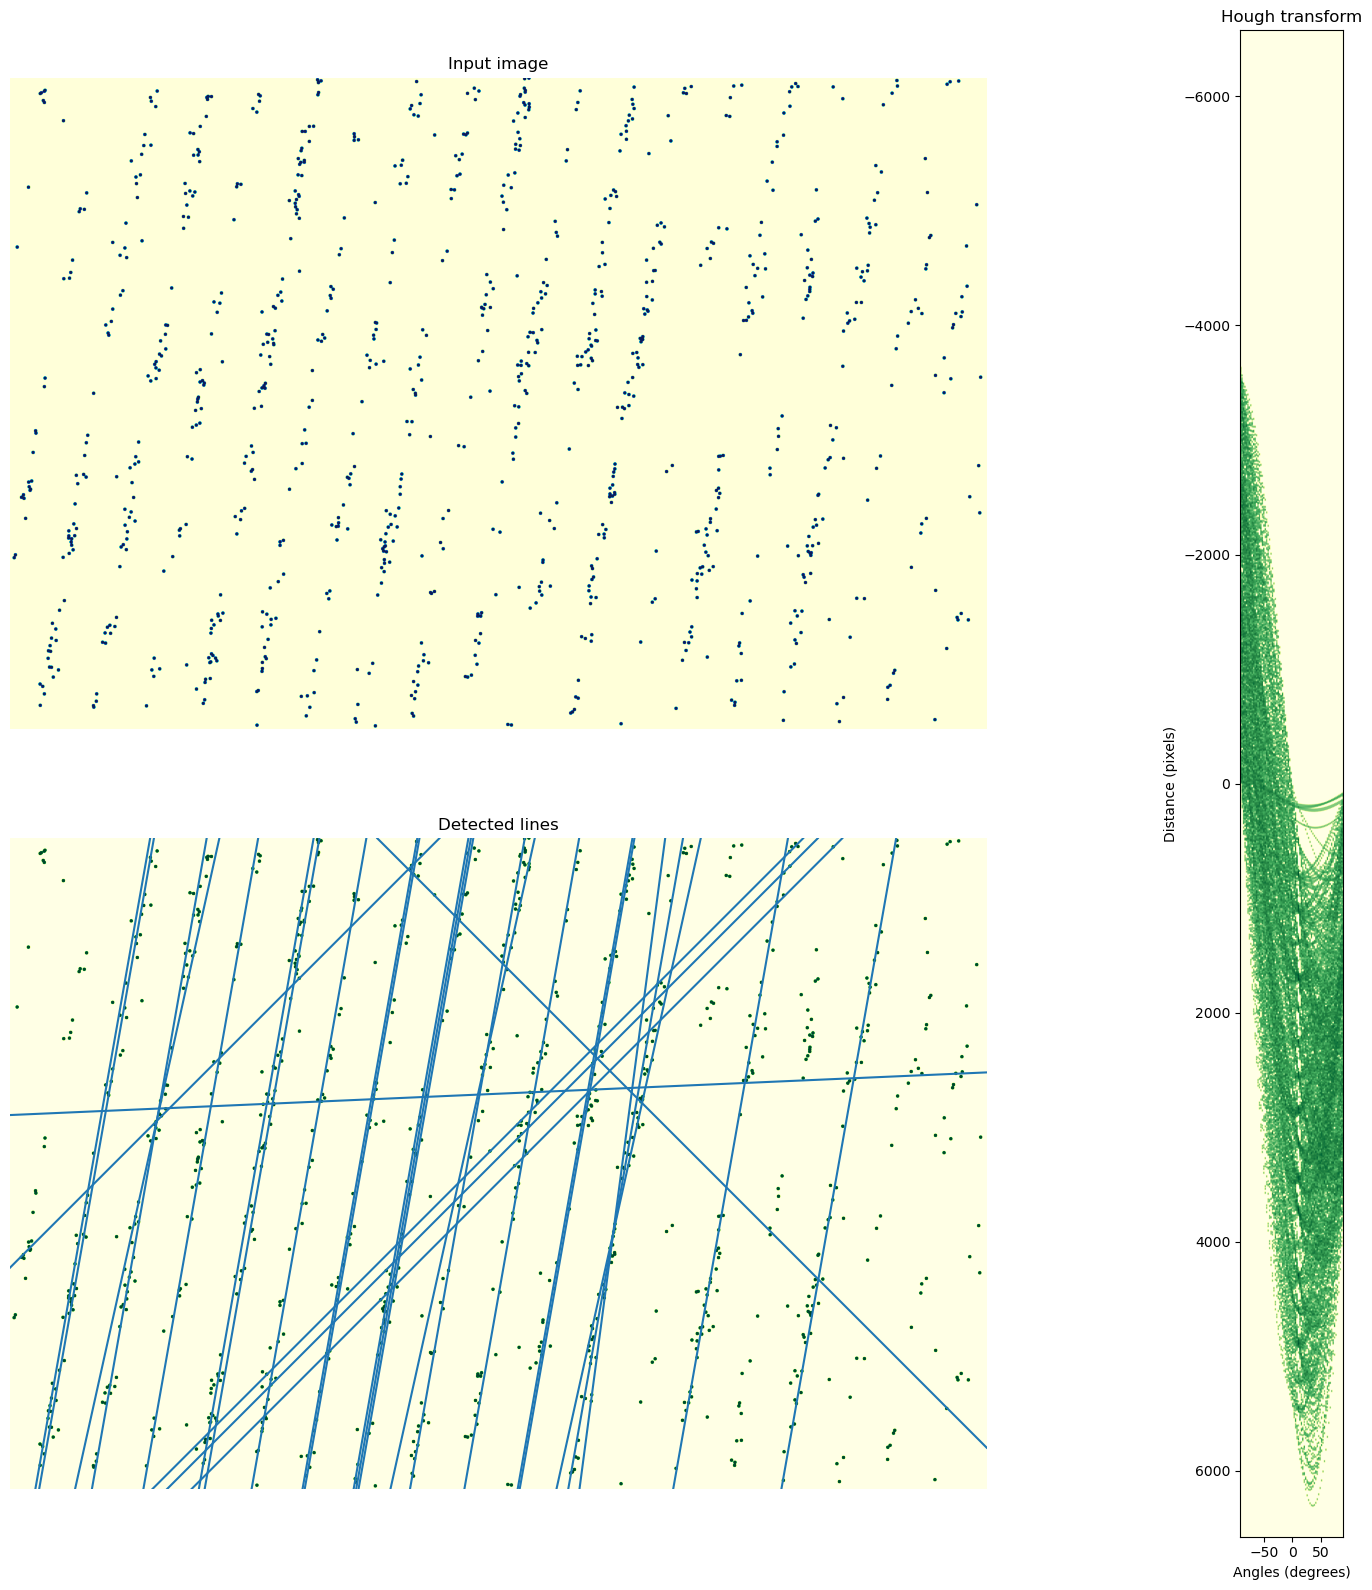

In [121]:
selImage = im

# Classic straight-line Hough transform
# Set a precision of 2 degree.

precision = 2.5 # Probar distintos valores precisión (ángulo theta)

tested_angles = np.linspace(-np.pi / 2, np.pi / 2, int(180 / precision), endpoint=False)
h, theta, d = hough_line(selImage, theta=tested_angles)

#cv2.HoughLines(image, rho=1, theta=np.pi/180, threshold=100) # Ajustar Umbral y Rho

# Generating figure 1
fig = plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(2,2)

ax0 = plt.subplot(gs[0,0])
ax0.imshow(selImage, cmap=cm.YlGnBu)
ax0.set_title('Input image')
ax0.set_axis_off()

ax1 = plt.subplot(gs[:,1])
angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]
ax1.imshow(np.log(1 + h), extent=bounds, cmap=cm.YlGn, aspect=1 / 1.5)
ax1.set_title('Hough transform')
ax1.set_xlabel('Angles (degrees)')
ax1.set_ylabel('Distance (pixels)')
ax1.axis('image')
ax1.set_aspect(.2)

ax2 = plt.subplot(gs[1,0])
ax2.imshow(selImage, cmap=cm.YlGn)
ax2.set_ylim((selImage.shape[0], 0))
ax2.set_xlim((0,selImage.shape[1]))
ax2.set_axis_off()
ax2.set_title('Detected lines')

detected_lines = []
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    detected_lines.append({'angle': angle, 'distance': dist, 'point': (x0, y0), 'slope': np.tan(angle + np.pi / 2)})
    ax2.axline((x0, y0), slope=np.tan(angle + np.pi/2))
    
plt.tight_layout()
plt.show()

In [ ]:
print(f"Se han detectado un total de {len(detected_lines)} líneas.")

# Eliminación falsos positivos

In [ ]:
import numpy as np
from collections import Counter

angles = []
for i in range(len(detected_lines)):
    angle = detected_lines[i]['angle']
    angles.append(angle)
   # print(i, angle)

print("ÁNGULO DE LAS LÍNEAS")
mean_angle = np.mean(angles)
print("Media: ", mean_angle)
std_dev = np.std(angles)
print("Desv. Est.: ", std_dev)

counter = Counter(angles)
most_common = counter.most_common(1)  # Devuelve una lista con el valor más frecuente y su frecuencia

# Resultado
if most_common:
    print(f"Valor más común: {most_common[0][0]}, Frecuencia: {most_common[0][1]}")

In [ ]:
# Sensibilidad
threshold = 1e-2

# Definir límites basados en 2 desviaciones estándar
lower_limit = most_common[0][0] - threshold #* std_dev
upper_limit = most_common[0][0] + threshold #* std_dev

# Validar si los valores están dentro del rango
validation = [(lower_limit <= angle <= upper_limit) for angle in angles]

# Mostrar resultados
print(f"Límite inferior: {lower_limit}")
print(f"Límite superior: {upper_limit}")
print(f"Validaciones: {validation}")

In [ ]:
angles = np.array(angles)
validation = np.array(validation)

valid_angles = []
for i in range(len(detected_lines)):
    if validation[i]:
        valid_angles.append(detected_lines[i])
        
    #x0, y0 = line['point']
    #slope = line['slope']

#print("Corrección:", valid_angles)

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot()

# Mostrar la imagen original
ax.imshow(selImage, cmap=cm.YlGn)
ax.set_ylim((selImage.shape[0], 0))
ax.set_xlim((0, selImage.shape[1]))
ax.set_title('Filtered lines (Corrección)')

# Graficar solo las líneas filtradas
for line in valid_angles:
    x0, y0 = line['point']
    slope = line['slope']
    ax.axline((x0, y0), slope=slope, color='red')  # Líneas filtradas en rojo

    # Dibujar el punto
    ax.plot(x0, y0, 'o')


# Configurar el gráfico
ax.set_title("Líneas detectadas y puntos asociados")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.grid(True)
plt.show()
"""
# Test
altura, anchura = selImage.shape[:2]
x1, y1 = anchura/2, altura/2
slope1 = 1
ax.axline((x1, y1), slope=slope1, color='blue')
"""

plt.tight_layout()
plt.show()


In [ ]:
print(f"Se redujo el número de líneas posibles a {len(valid_angles)}.")

# Eliminación líneas cercanas

In [ ]:
print(math.degrees(abs((most_common[0][0]))))
if math.degrees(abs(most_common[0][0])) < 45:
    print("Distribución vertical")
else:
    print("Distribución horizontal")

In [ ]:
# Detecta si la orientación de la imágen es horizontal o vertical
print(math.degrees(abs((most_common[0][0]))))
if math.degrees(abs(most_common[0][0])) < 45:
    print("Distribución vertical")
    # Si es horizontal aplica la búsqueda en el eje Y
    valid_angles = sorted(valid_angles, key=lambda line: line['point'][0])
    df_lines = pd.DataFrame(valid_angles)
    df_lines['x0'] = df_lines['point'].apply(lambda p: p[0])
    df_lines['x1'] = df_lines['x0'].shift(+1)
    df_lines['dist'] = df_lines['x0'] - df_lines['x1']
else:
    print("Distribución horizontal")
    # Si es horizontal aplica la búsqueda en el eje Y
    valid_angles = sorted(valid_angles, key=lambda line: line['point'][1])
    df_lines = pd.DataFrame(valid_angles)
    df_lines['y0'] = df_lines['point'].apply(lambda p: p[1])
    df_lines['y1'] = df_lines['y0'].shift(+1)
    df_lines['dist'] = df_lines['y0'] - df_lines['y1']

mean_dist = df_lines['dist'].mean()
std_dist = df_lines['dist'].std()
df_lines.fillna(mean_dist, inplace=True)

# Calcular la media y la desviación estándar de las distancias
print("SEPARACIÓN DE LAS LÍNEAS")
print("Media: ", mean_dist)
print("Desv. Est.: ", std_dist)

# Calcular el umbral
threshold = mean_dist / 2
print("threshold: ", round(threshold,2))

if math.degrees(abs(most_common[0][0])) < 45:
    # Filtrar las líneas cuya distancia es menor al umbral
    crop_lines = df_lines[df_lines['dist'] > threshold]
    df_lines.drop(columns=['x0','x1','dist'], inplace = True)
else:
    # Filtrar las líneas cuya distancia es menor al umbral
    crop_lines = df_lines[df_lines['dist'] > threshold]
    df_lines.drop(columns=['y0','y1','dist'], inplace = True)


# Mostrar el DataFrame filtrado
crop_lines

In [ ]:
df_lines

In [ ]:
crop_lines = crop_lines.to_dict(orient='records')

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot()

# Mostrar la imagen original
#ax.imshow(selImage, cmap=cm.YlGn)
ax.imshow(masked_image, cmap='gray')
ax.set_ylim((selImage.shape[0], 0))
ax.set_xlim((0, selImage.shape[1]))
ax.set_title('Filtered lines (Corrección)')

# Graficar solo las líneas filtradas
for line in crop_lines:
    x0, y0 = line['point']
    slope = line['slope']
    ax.axline((x0, y0), slope=slope, color='red')  # Líneas filtradas en rojo

    # Dibujar el punto
    ax.plot(x0, y0, 'o')


# Configurar el gráfico
ax.set_title("Líneas detectadas y puntos asociados")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.grid(True)
plt.show

plt.tight_layout()
plt.show()


**PARA SOLUCIONAR:**
1. Detección de líneas en los límites (problema algoritmo)
2. Detección líneas poco pobladas

In [ ]:
print(f"Luego de eliminar falsos positivos, se detectan un total de {len(crop_lines)} líneas.")

# Resultado de los experimentos
__*Método 0 - Umbral fijo (50): (ExG, Canny 2, Hough 2)*__

- 503_120_29 -> 17/17 lineas (100%)
- 503_121_43 -> 14/19 lineas (74%)
- 503_119_43 -> 21/24 lineas (88%)
- 209_206_54 -> 12/20 lineas (60%) _thresh 100_

__*Método 0 - Umbral fijo (50): (ExG, Canny 3, Hough 2)*__

- 503_120_29 -> 16/17 lineas (94%)
- 503_121_43 -> 16/19 lineas (84%)
- 503_119_43 -> 21/24 lineas (88%)
- 209_206_54 -> 11/20 lineas (55%) thresh 100


__*Método 1 - OTSU: (ExG + Mask, Canny 2, Hough 2)*__

- 503_120_29 -> 14/17 lineas (82%)
- 503_121_43 -> 15/19 lineas (79%)
- 503_119_43 -> 19/24 lineas (79%)
- 209_206_54 -> 16/20 lineas (80%)
 
__*Método 0 - Umbral fijo (50): (ExG, Canny 3, Hough 2)*__

- 503_120_29 -> 16/17 lineas (94%)
- 503_121_43 -> 16/19 lineas (84%)
- 503_119_43 -> 21/24 lineas (88%)
- 209_206_54 -> 11/20 lineas (55%) thresh 100


__*Método 3 - Percentiles: (ExG + Mask, Canny 2, Hough 2)*__

- 503_120_29 -> 14/17 lineas (82%)
- 503_121_43 -> 16/19 lineas (84%)
- 503_119_43 -> 21/24 lineas (88%)
- 209_206_54 -> 15/20 lineas (75%)